In [1]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
K = tc.set_backend('jax')

In [3]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0


def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = y == a
    return x, y

x_train, y_train = filter_pair(x_train, y_train, 0, 1)
x_train_small = tf.image.resize(x_train[..., tf.newaxis], (16, 16)).numpy()[..., 0].reshape(-1, 256)
x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))

In [4]:
x_train_small.shape

(12665, 256)

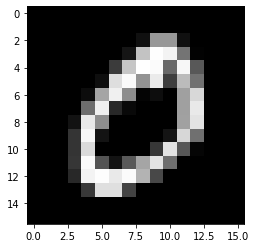

In [5]:
plt.imshow(x_train_small[0].reshape(16, 16), cmap='gray')

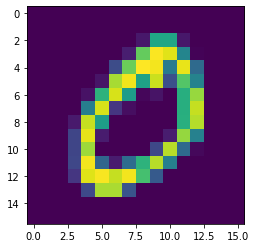

In [6]:
c = tc.Circuit(8, inputs=x_train_small[0])

plt.imshow(jnp.real(c.wavefunction().reshape(16, 16)))


In [7]:
data = tf.data.Dataset.from_tensor_slices((x_train_small, y_train)).shuffle(100).batch(128)

In [8]:
def loss(params, x, y, k):
    c = tc.Circuit(8, inputs=x)
    for j in range(k):
        for i in range(8 - 1):
            c.cnot(i, i + 1)
        for i in range(8):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = (jnp.real(c.expectation([tc.gates.z(), [0,]])) + 1) / 2
    return -(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
loss = K.jit(loss, static_argnums=[3])

In [9]:
def accuracy(params, x, y, k):
    c = tc.Circuit(8, inputs=x)
    for j in range(k):
        for i in range(8 - 1):
            c.cnot(i, i + 1)
        for i in range(8):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = jnp.round((jnp.real(c.expectation([tc.gates.z(), [0,]])) + 1) / 2)
    return y_pred == y
accuracy = K.jit(accuracy, static_argnums=[3])

In [10]:
k = 6
params = K.randn((k * 2, 8), dtype=jnp.float32)

In [11]:
opt = optax.adam(learning_rate=1e-2)
opt_state = opt.init(params)

In [12]:
compute_loss = K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2])
compute_accuracy = K.vmap(accuracy, vectorized_argnums=[1, 2])

In [13]:
loss_list = []
acc_list = []
for e in tqdm(range(2)):
    for i, (x, y) in enumerate(data):
        x = x.numpy()
        y = y.numpy()
        loss_val, grad_val = compute_loss(params, x, y, k)
        updates, opt_state = opt.update(grad_val, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_mean = jnp.mean(loss_val)
        if i % 10 == 0:
            acc = jnp.mean(compute_accuracy(params, x, y, k))
            acc_list.append(acc)
            loss_list.append(loss_mean)
            print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 0, 0/99: loss=0.6863, acc=0.5234
epoch 0, 10/99: loss=0.6540, acc=0.7188
epoch 0, 20/99: loss=0.6248, acc=0.8906
epoch 0, 30/99: loss=0.5928, acc=0.9141
epoch 0, 40/99: loss=0.5717, acc=0.9219
epoch 0, 50/99: loss=0.5443, acc=0.9453
epoch 0, 60/99: loss=0.5171, acc=0.9453
epoch 0, 70/99: loss=0.5182, acc=0.9531
epoch 0, 80/99: loss=0.4903, acc=0.9922
epoch 0, 90/99: loss=0.4809, acc=1.0000
epoch 1, 0/99: loss=0.5027, acc=0.9609
epoch 1, 10/99: loss=0.4681, acc=0.9922
epoch 1, 20/99: loss=0.4828, acc=0.9922
epoch 1, 30/99: loss=0.4666, acc=0.9922
epoch 1, 40/99: loss=0.4797, acc=0.9531
epoch 1, 50/99: loss=0.4714, acc=0.9844
epoch 1, 60/99: loss=0.4545, acc=1.0000
epoch 1, 70/99: loss=0.4773, acc=0.9922
epoch 1, 80/99: loss=0.4608, acc=0.9844
epoch 1, 90/99: loss=0.4518, acc=0.9922


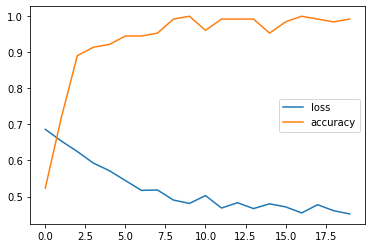

In [14]:
plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.show()

In [15]:
def pred(params, x, y, k):
    c = tc.Circuit(8, inputs=x)
    for j in range(k):
        for i in range(8 - 1):
            c.cnot(i, i + 1)
        for i in range(8):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = jnp.round((jnp.real(c.expectation([tc.gates.z(), [0,]])) + 1) / 2)
    return y_pred
pred = K.jit(pred, static_argnums=[3])

In [16]:
prediction = K.vmap(pred, vectorized_argnums=[1, 2])(params, x_train_small[:1000], y_train[:1000], k)

In [17]:
jnp.mean(y_train[:1000]*1.0==prediction)

DeviceArray(0.98800004, dtype=float32)